In [1]:
# Notebook: Aktienkursanalyse und Verknüpfung mit Finanznachrichten
# 
# Dieses Notebook zeigt exemplarisch:
# - wie Aktienkursdaten über yfinance geladen werden,
# - wie diese mit den zuvor ermittelten Sentimentdaten der Finanznachrichten
#   zusammengeführt werden,
# - und wie Korrelationen zwischen Sentiment und Tagesrenditen berechnet werden.
#
# Datenhinweis:
# - Die Finanznachrichten-Daten (CSV) sind NICHT im Repository enthalten
#   und müssen extern bereitgestellt werden (siehe README).
# - Aktienkursdaten werden direkt über yfinance heruntergeladen.

In [2]:
# Bibliotheken laden
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Einheitliche Farben für alle Unternehmen
farben_unternehmen = {
    "SAP": "#006BB8",         # Blau
    "Siemens": "#009999",     # Grün
   "Allianz": "#ff7f0e",     # Orange
    "Telekom": "#E20074",     # Magenta
      "Rheinmetall": "#3E3D40"  # Grau
}

In [5]:
# Aktienkurse von yfinance laden

# Liste der Unternehmen-Ticker
# SAP.DE = SAP
# SIE.DE = Siemens
# RHM.DE = Rheinmetall
# DTE.DE = Deutsche Telekom
# ALV.DE = Allianz
tickers = ["SAP.DE", "SIE.DE", "RHM.DE", "DTE.DE", "ALV.DE"]

# Zeitraum festlegen: 01.01.2020 - 10.06.2025
start = "2020-01-01"
end   = "2025-06-10"

# Kurse herunterladen
# Open, High, Low, Close, Volume und Adj Close
df_prices = yf.download(
    tickers,
    start=start,
    end=end,
    interval="1d",        # tägliche Kurse
    group_by="ticker",    # gruppiert die Daten pro Ticker
    auto_adjust=True      # liefert automatisch bereinigte Kurse (Dividenden/Splits verrechnet)
)

# In ein “long format” umwandeln
df_aktien = (
    df_prices.stack(level=0, future_stack=True) # Ticker-Ebene nach unten stapeln
             .reset_index() # Index in Spalten umwandeln
             .rename(columns={"level_1":"Ticker"})
)

# Überblick
print(df_aktien.info())
print(df_aktien.head())

[*********************100%***********************]  5 of 5 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6925 entries, 0 to 6924
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6925 non-null   datetime64[ns]
 1   Ticker  6925 non-null   object        
 2   Open    6925 non-null   float64       
 3   High    6925 non-null   float64       
 4   Low     6925 non-null   float64       
 5   Close   6925 non-null   float64       
 6   Volume  6925 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 378.8+ KB
None
Price       Date  Ticker        Open        High         Low       Close  \
0     2020-01-02  SIE.DE   88.264758   90.160477   88.264758   89.963326   
1     2020-01-02  RHM.DE   91.779151   92.989129   91.151751   92.809875   
2     2020-01-02  ALV.DE  161.184176  163.912360  161.036697  163.322479   
3     2020-01-02  SAP.DE  109.303322  111.859694  109.029422  111.384941   
4     2020-01-02  DTE.DE   11.

In [6]:
# Datumsformat vereinheitlichen
df_aktien["Datum"] = pd.to_datetime(df_aktien["Date"]).dt.normalize()

In [7]:
df_aktien.columns

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Datum'], dtype='object', name='Price')

In [8]:
# Daten sichern
df_aktien.to_csv("df_aktien.csv", index=False)

In [9]:
# Finanznachrichten-Datei laden
df_agg_tag_unternehmen = pd.read_csv('df_agg_tag_unternehmen.csv', encoding='utf-8')

In [10]:
# Datum in datetime-Format umwandeln
df_agg_tag_unternehmen["Datum"] = pd.to_datetime(df_agg_tag_unternehmen["Datum"], format="%Y-%m-%d")
# Überprüfung, ob Zeitraum korrekt ist
print(df_agg_tag_unternehmen["Datum"].min(), df_agg_tag_unternehmen["Datum"].max())

2020-01-04 00:00:00 2025-06-07 00:00:00


In [11]:
# Mergen der Datensätze
# Mapping von Unternehmensname und Ticker
# Der Nachrichten‑DF hat in der explode-Phase die Spalte "Gefundene_Unternehmen" erhalten
mapping = {
    "SAP": "SAP.DE",
    "Siemens": "SIE.DE",
    "Rheinmetall": "RHM.DE",
    "Telekom": "DTE.DE",
    "Allianz": "ALV.DE"
}

# Neue Spalte "Ticker" im Nachrichten-DF
df_agg_tag_unternehmen["Ticker"] = df_agg_tag_unternehmen["Gefundene_Unternehmen"].map(mapping)

In [12]:
print(df_agg_tag_unternehmen.columns)
print(df_aktien.columns)


Index(['Datum', 'Gefundene_Unternehmen', 'Anzahl_Artikel', 'Mean_Sentiment',
       'Mean_Confidence', 'Sentiment_Rolling30', 'Ticker'],
      dtype='object')
Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Datum'], dtype='object', name='Price')


In [13]:
# Left‑Join: behalte alle Nachrichtentitel, ergänzt um Kursdaten des jeweiligen Tages
df_merged = pd.merge(
    df_agg_tag_unternehmen,
    df_aktien,
    on=["Datum", "Ticker"],
    how="left",
    validate="many_to_one"
)

# Kurzer Blick
print(df_merged.shape)

(1908, 13)


In [14]:
# Zeigt Spaltennamen, Datentypen, Anzahl nicht-leerer Einträge und Anzahl der eindeutigen Werte
struktur_df_merged = pd.DataFrame({
    "Spalte": df_merged.columns,
    "Datentyp": df_merged.dtypes.values,
    "Nicht-Null Werte": df_merged.notnull().sum().values,
    "Anzahl eindeutiger Werte": df_merged.nunique().values
})
struktur_df_merged.style.set_caption("Struktur des gemergten Datensatzes")

,Spalte,Datentyp,Nicht-Null Werte,Anzahl eindeutiger Werte
0,Datum,datetime64[ns],1908,1214
1,Gefundene_Unternehmen,object,1908,5
2,Anzahl_Artikel,int64,1908,10
3,Mean_Sentiment,float64,1908,25
4,Mean_Confidence,float64,1908,1797
5,Sentiment_Rolling30,float64,1908,436
6,Ticker,object,1908,5
7,Date,datetime64[ns],1141,788
8,Open,float64,1141,1139
9,High,float64,1141,1139


In [15]:
# Fehlende Kurse prüfen & Umgang mit fehlenden Werten (Aktienkursdaten)

# fehlende Close-Kurse (Börsenfeiertage)
missing = df_merged[df_merged["Close"].isna()]
print("Keine Close-Kursdaten für", missing.shape[0], "Nachrichten (z.B. Wochenende/Feiertag).")

Keine Close-Kursdaten für 767 Nachrichten (z.B. Wochenende/Feiertag).


In [16]:
# Funktion zum Umgang mit fehlen Aktienkursdaten
# nächstmöglichen Kurswert
def finde_naechsten_kurs(row, df_kurse, max_tage=5):
    """Findet den nächstmöglichen Kurs für einen Ticker nach einem gegebenen Datum."""
    if pd.notna(row["Close"]):
        return row["Close"], row ["Open"],row["Datum"]  # Kurs bereits vorhanden

    ticker = row["Ticker"]
    datum = row["Datum"]
    
    # Alle Kurse dieses Unternehmens nach dem gegebenen Datum (max_tage)
    kurse = df_kurse[
        (df_kurse["Ticker"] == ticker) & 
        (df_kurse["Datum"] > datum) & 
        (df_kurse["Datum"] <= datum + pd.Timedelta(days=max_tage))
    ].sort_values("Datum")

    if not kurse.empty:
        # Nächster gültiger Kurs + zugehöriges Datum
        zeile = kurse.iloc[0]
        return zeile["Close"], zeile["Open"], zeile["Datum"]
    
    return np.nan, np.nan, pd.NaT  # Kein Kurs gefunden

In [17]:
# Apply auf df_merged (gemergter DataFrame)
df_merged[["Close_filled", "Open_filled", "Datum_kurs_filled"]] = df_merged.apply(
    lambda row: finde_naechsten_kurs(row, df_aktien), axis=1, result_type="expand"
)

In [18]:
# Prüfen, ob Duplikate vorliegen
print(f"Number of duplicate rows: {df_merged.duplicated().sum()}")

Number of duplicate rows: 0


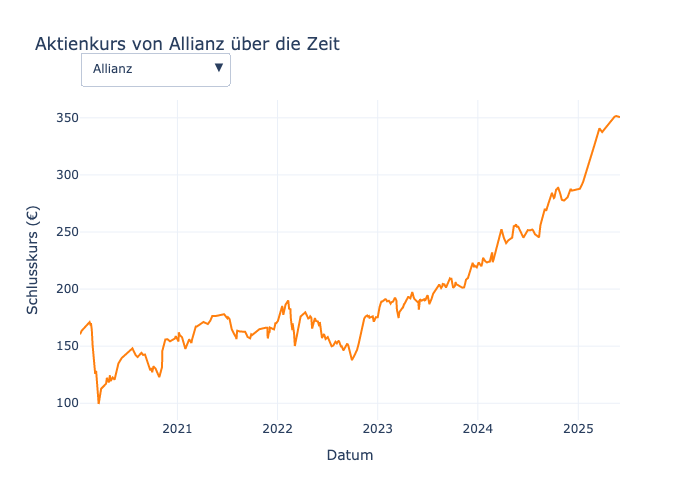

In [19]:
# Aktienkurse der fünf Unternehmen im Zeitverlauf

unternehmen = sorted(df_merged["Gefundene_Unternehmen"].unique())

# Layout vorbereiten
fig = go.Figure()

# Für jedes Unternehmen eine eigene Linie hinzufügen (initial alle sichtbar, später via Dropdown steuerbar)
for i, name in enumerate(unternehmen):
    visible = True if i == 0 else False  # Nur erstes Unternehmen sichtbar beim Start
    df_u = df_merged[df_merged['Gefundene_Unternehmen'] == name]
    fig.add_trace(go.Scatter(
        x=df_u['Datum'],
        y=df_u['Close_filled'],
        mode='lines',
        name=name,
        visible=visible,
        line=dict(color=farben_unternehmen.get(name, '#000000'))  # fallback schwarz
    ))

# Dropdown-Menü erstellen
buttons = []
for i, name in enumerate(unternehmen):
    # Sichtbarkeit für alle Traces setzen (nur i ist True)
    visible_array = [j == i for j in range(len(unternehmen))]
    buttons.append(dict(
        label=name,
        method='update',
        args=[{'visible': visible_array},
              {'title': f'Aktienkurs von {name} über die Zeit'}]
    ))

# Button für "Alle Unternehmen"
buttons.append(dict(
    label='Alle Unternehmen',
    method='update',
    args=[{'visible': [True] * len(unternehmen)},
          {'title': 'Aktienkurse aller Unternehmen über die Zeit'}]
))

# Dropdown ins Layout einfügen
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.0,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
    title=f"Aktienkurs von {unternehmen[0]} über die Zeit",
    xaxis_title="Datum",
    yaxis_title="Schlusskurs (€)",
    template="plotly_white"
)

fig.show()

In [20]:
# Tagesrendite berechnen
df_merged["Rendite_%"] = ((df_merged["Close_filled"] - df_merged["Open_filled"]) / df_merged["Open_filled"]) * 100
df_merged.head()

,Datum,Gefundene_Unternehmen,Anzahl_Artikel,Mean_Sentiment,Mean_Confidence,Sentiment_Rolling30,Ticker,Date,Open,High,Low,Close,Volume,Close_filled,Open_filled,Datum_kurs_filled,Rendite_%
0,2020-01-12,Allianz,1,0.0,0.997261,0.0,ALV.DE,NaT,NaN,NaN,NaN,NaN,NaN,161.958389,163.138150,2020-01-13,-0.723167
1,2020-01-14,Allianz,1,0.0,0.994978,0.0,ALV.DE,2020-01-14,161.995269,162.069008,160.704911,161.36853,827509.0,161.368530,161.995269,2020-01-14,-0.386887
2,2020-01-18,Allianz,1,0.0,0.992196,0.0,ALV.DE,NaT,NaN,NaN,NaN,NaN,NaN,163.469955,161.810923,2020-01-20,1.025291
3,2020-02-16,Allianz,2,0.0,0.996983,0.0,ALV.DE,NaT,NaN,NaN,NaN,NaN,NaN,171.064651,170.990912,2020-02-17,0.043125
4,2020-02-20,Allianz,3,0.0,0.997273,0.0,ALV.DE,2020-02-20,171.064640,171.064640,168.115250,168.11525,998151.0,168.115250,171.064640,2020-02-20,-1.724138


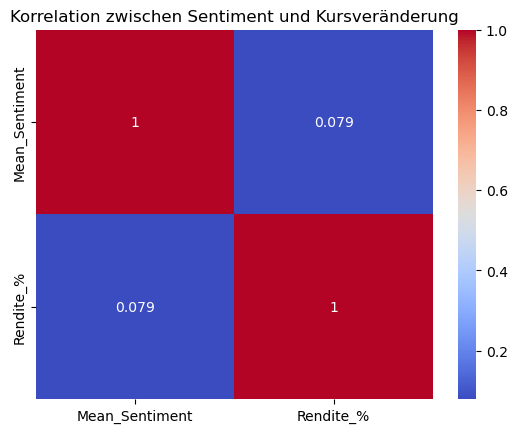

In [21]:
# Korrelationsanalyse: Sentiment und Tagesrendite

# Korrelation
corr = df_merged[['Mean_Sentiment', 'Rendite_%']].corr()

# Visualisieren
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Korrelation zwischen Sentiment und Kursveränderung")
plt.show()

Anzahl Zeilen für Korrelation (Close nicht NA): 1141


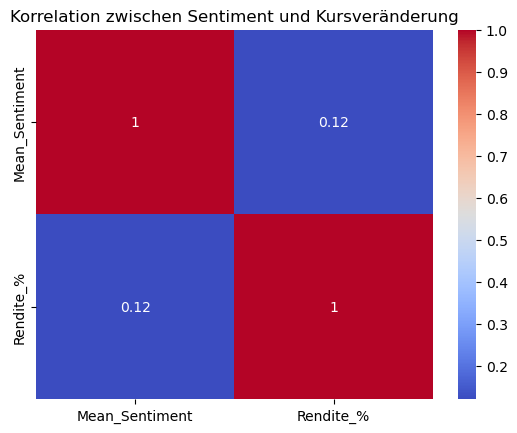

In [22]:
# Korrelationsanalyse: Sentiment und Tagesrendite nur für Fälle, bei denen am gleichen Tag Aktienkurse vorliegen (Close ≠ NA)
subset2 = df_merged.loc[df_merged["Close"].notna(), ['Mean_Sentiment', 'Rendite_%']].dropna()
print("Anzahl Zeilen für Korrelation (Close nicht NA):", len(subset2))
corr2 = subset2.corr()

# Korrelation
cols = ['Mean_Sentiment', 'Rendite_%']
corr = df_merged.loc[df_merged["Close"].notna(), cols].dropna().corr()

# Visualisieren
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Korrelation zwischen Sentiment und Kursveränderung")
plt.show()

In [23]:
# Korrelation zwischen dem Sentiment in Finanznachrichtentiteln und der Tagesrendite der Aktien pro Unternehmen 

# Nur Zeilen mit nicht fehlendem Close berücksichtigen
df_filtered = df_merged[df_merged["Close"].notna()]

for name, group in df_filtered.groupby('Gefundene_Unternehmen'):
    corr = group[['Mean_Sentiment', 'Rendite_%']].corr().iloc[0, 1]
    print(f"{name}: Korrelation Sentiment ↔ Tagesveränderung = {corr:.2f}")

Allianz: Korrelation Sentiment ↔ Tagesveränderung = 0.10
Rheinmetall: Korrelation Sentiment ↔ Tagesveränderung = 0.19
SAP: Korrelation Sentiment ↔ Tagesveränderung = 0.11
Siemens: Korrelation Sentiment ↔ Tagesveränderung = 0.14
Telekom: Korrelation Sentiment ↔ Tagesveränderung = 0.04


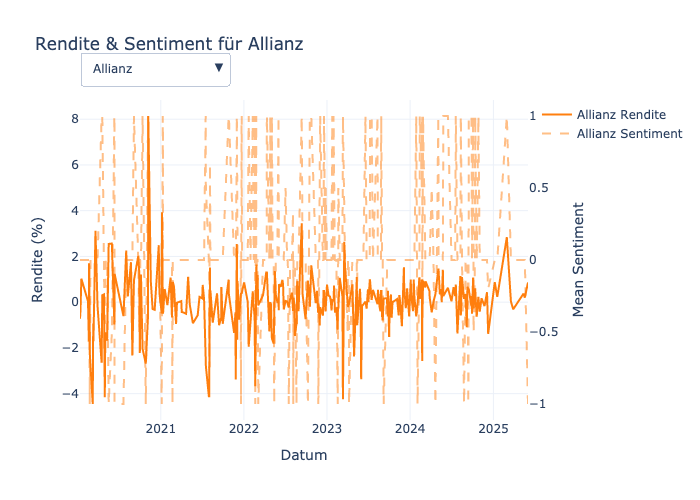

In [24]:
# Zeitreihendiagramm: Aktienkurs und Sentiment
unternehmen = sorted(df_merged['Gefundene_Unternehmen'].unique())

def adjust_color_opacity(hex_color, opacity=0.5):
    # Wandelt Hex-Farbe in rgba mit Opazität um
    hex_color = hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2],16), int(hex_color[2:4],16), int(hex_color[4:6],16)
    return f'rgba({r},{g},{b},{opacity})'

farben_unternehmen = {
    "SAP": "#006BB8",        # Blau
    "Siemens": "#009999",    # Grün
    "Allianz": "#ff7f0e",    # Orange
    "Telekom": "#E20074",    # Magenta
    "Rheinmetall": "#3E3D40" # Grau
}

fig = go.Figure()

for i, name in enumerate(unternehmen):
    df_u = df_merged[df_merged['Gefundene_Unternehmen'] == name]
    
    visible = True if i == 0 else False  # nur erstes Unternehmen sichtbar
    
    # Linie 1: Close_filled (durchgezogen)
    fig.add_trace(go.Scatter(
        x=df_u['Datum'],
        y=df_u['Rendite_%'],
        mode='lines',
        name=f'{name} Rendite',
        visible=visible,
        line=dict(color=farben_unternehmen.get(name, '#000000'), width=2),
        legendgroup=name,
        showlegend=True,
    ))
    
    # Linie 2: Mean_Sentiment (gestrichelt)
    fig.add_trace(go.Scatter(
        x=df_u['Datum'],
        y=df_u['Mean_Sentiment'],
        mode='lines',
        name=f'{name} Sentiment',
        visible=visible,
        line=dict(
            color=adjust_color_opacity(farben_unternehmen.get(name, '#000000'), 0.5),
            dash='dash',
            width=2
        ),
        marker=dict(
            size=6,
            symbol='circle',
            color=adjust_color_opacity(farben_unternehmen.get(name, '#000000'), 0.7)
        ),
        yaxis='y2',
        legendgroup=name,
        showlegend=True,
    ))

n = len(unternehmen)

buttons = []
for i, name in enumerate(unternehmen):
    visible_array = [False] * 2 * n
    visible_array[2*i] = True      # Close Linie sichtbar
    visible_array[2*i + 1] = True  # Sentiment Linie sichtbar
    buttons.append(dict(
        label=name,
        method='update',
        args=[{'visible': visible_array},
              {'title': f'Rendite & Sentiment für {name}'}]
    ))

buttons.append(dict(
    label='Alle Unternehmen',
    method='update',
    args=[{'visible': [True] * 2 * n},
          {'title': 'Rendite & Sentiment für alle Unternehmen'}]
))

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0,
        xanchor='left',
        y=1.15,
        yanchor='top'
    )],
    title=f'Rendite & Sentiment für {unternehmen[0]}',
    xaxis_title='Datum',
    yaxis=dict(
        title='Rendite (%)',
        side='left',
        showgrid=True,
        zeroline=False
    ),
    yaxis2=dict(
        title='Mean Sentiment',
        overlaying='y',
        side='right',
        showgrid=False,
        zeroline=False
    ),
    template='plotly_white',
    legend=dict(
        tracegroupgap=0
    )
)

fig.show()